# Food Classification to Audio for the Blind 
### Team: Rachel Kiehne, Rodney Small, Rudra Shah
> ### Tufts Gordon Institute, EM-0213 Advanced Data Analytics, Spring 2022

----
## Problem Statement
#### By classifying food images using AI technology, we could use this to help train augmented reality glasses for the visually impairmented, such that device could auditorily inform its wearer of what they are going to consume.
---
To solve this problem, we will train the dataset to classify different types of food such that the response of the algorithm determines which classification exists. The parameters in which we have determined are based on the existing AI measures and qualifications that were established in the already present dataset (Food-101). 
<br><br>

While at first, we thought we could tackle the problem of food versus non-food images, we found that problem to be too monumental to tackle. By classifying the types of foods, it is just as important to the beginnings of our goal as we can establish commonalities amongst different images. 
<br><br>

#### *Why is this important?*
As mentioned previously, this project could be used to train smart glasses that when scanning food items could help individuals whom are visually impaired make executive decisions autonomously. This would alleviate the need for additional human assistive help.  

In [ ]:
from pathlib import Path
from fastai.vision import * # https://fastai1.fast.ai/imports.html
from fastai.metrics import error_rate

In [ ]:
import warnings

In [ ]:
batch_size = 128   # batch size
arch = models.resnet34

## Data Import

In [ ]:
# mount data from google drive, if needed
drive_mount_path = '/content/drive'
from google.colab import drive
if not os.path.exists(drive_mount_path):
  drive.mount(drive_mount_path)

Mounted at /content/drive


In [ ]:
path = Path(os.path.join('/content'))
path_h5 = path
path_img = path/'images'
path_meta = path/'meta/meta'
path_working = path/'working/'
path_audio = f'{drive_mount_path}/MyDrive/Colab Notebooks/audio'
path_new_images = f'{drive_mount_path}/MyDrive/Colab Notebooks/new-images'
path_last_model = f'{drive_mount_path}/MyDrive/Colab Notebooks/last-food-models'

In [ ]:
!ls "$path_last_model"

food-detection-save.jpg   food-mini-training-2.pth  predict-training-2.jpg
food-mini-training-1.pth  predict-training-1.jpg


In [ ]:
# make our working folders (silently)
!mkdir $path_working > /dev/null 2>&1
!mkdir -p $path_audio > /dev/null 2>&1
!mkdir -p $path_last_model > /dev/null 2>&1

In [ ]:
# DO THIS ONLY ONCE - take a bit of time and ~6GB storage needed
# unzip food 101 zip file (mounted on drive)
if not os.path.exists(path_img):
  !unzip '/content/drive/MyDrive/Colab Notebooks/kaggle-food-101.zip' > /dev/null 2>&1


In [ ]:
# check images folder now exists
!ls {path_img} | head

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [ ]:
# Modify the from folder function in fast.ai to use the dictionary mapping from folder to space seperated labels
def label_from_folder_map(class_to_label_map):
    return  lambda o: class_to_label_map[(o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2]]

In [ ]:
# Develop dictionary mapping from classes to labels
classes = pd.read_csv(path_meta/'classes.txt', header=None, index_col=0,) # 101 classes
labels = pd.read_csv(path_meta/'labels.txt', header=None) # 101 labels
classes['map'] = labels[0].values
classes_to_labels_map = classes['map'].to_dict() # {'apple_pie': 'Apple pie', 'baby_back_ribs': 'Baby back ribs',}
label_from_folder_food_func = label_from_folder_map(classes_to_labels_map)


In [ ]:
# labels from food folder image check
label_from_folder_food_func(Path(os.path.join('images','apple_pie','1005649.jpg')))

'Apple pie'

In [ ]:
# Setup the training ImageList for the DataBunch
train_df = pd.read_csv(path_meta/'train.txt', header=None).apply(lambda x : x + '.jpg')
train_image_list = ImageList.from_df(train_df, path_img)

# Setup the validation ImageList for the DataBunch
valid_df = pd.read_csv(path_meta/'test.txt', header=None).apply(lambda x : x + '.jpg')
valid_image_list = ImageList.from_df(valid_df, path_img)

In [ ]:
train_percent = train_df.size/(train_df.size+valid_df.size) * 100
valid_percent = valid_df.size/(train_df.size+valid_df.size) * 100
print(f'training size: {train_df.size} ({train_percent:0.0f}%) vs validation size: {valid_df.size} ({valid_percent:0.0f}%)')

training size: 75750 (75%) vs validation size: 25250 (25%)


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.solve")

def get_data(bs, size):
    """Function to return DataBunch with different batch and image sizes."""
    # combine training and validation image lists into one ImageList
    data = (train_image_list.split_by_list(train_image_list, valid_image_list))
    
    tfms = get_transforms() # get all transformations

    # label with function defined above using the mapping from folder name to labels
    # perform transformations and turn into a DataBunch
    data = data.label_from_func(label_from_folder_food_func).transform(
        tfms, size=size).databunch(bs=bs,  num_workers = 0).normalize(
        imagenet_stats)
    return data

data = get_data(batch_size, 128) # image sizes we have 32, 64,128

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


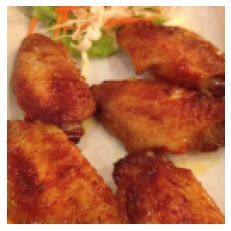

In [ ]:
type(data) # fastai.vision.data.ImageDataBunch
sample_image, sample_category = data.valid_ds[5059]
plt.imshow(sample_image.data.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
# valid label should be
sample_label = data.classes[sample_category.data]
sample_label

'Chicken wings'

In [ ]:
# sample of data labels
label_count = len(data.classes)
print(data.classes[0:10])

['Apple pie', 'Baby back ribs', 'Baklava', 'Beef carpaccio', 'Beef tartare', 'Beet salad', 'Beignets', 'Bibimbap', 'Bread pudding', 'Breakfast burrito']


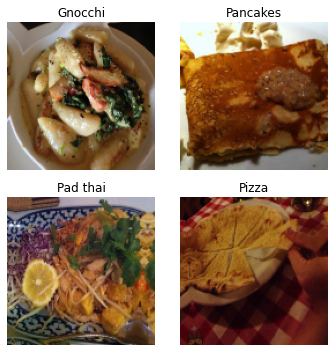

In [ ]:
data.show_batch(rows=2, figsize=(5,5),)

----
## Data Cleaning

> All the pictures that will be imported will need to be filtered based on the
> image quality, minimum pixel count needs to be met and the size for all the 
> pictures needs to be consistent to train the model in a specific manner. 

*Source image formats:*
>foodc101n1000_r384x384x3.h5 means there are 101 categories represented, with n=1000 images, that have a resolution of 384x384x3 (RGB, uint8)

> foodtestc101n1000r32x32x1.h5 means the data is part of the validation set, has 101 categories represented, with n=1000 images, that have a resolution of 32x32x1 (float32 from -1 to 1)


In [ ]:
labels.head()

0
0       Apple pie
1  Baby back ribs
2         Baklava
3  Beef carpaccio
4    Beef tartare

In [ ]:
classes.head()

map
0                             
apple_pie            Apple pie
baby_back_ribs  Baby back ribs
baklava                Baklava
beef_carpaccio  Beef carpaccio
beef_tartare      Beef tartare

## Model Training
The model that we used for solving the problem was resnet34. We believed that this model would accurately predict the classifications of images presented in our project. It is a CNN model and therefore training the program to branch in specific mannerisms fit. 
<br><br>
Using the model, we trained it using 100,000 images from Kaggle Food 101 source visible at the end of this notebook. The training size was 75,750 (75%) vs the validation size 25,250 (25%).
<br><br>

> #### Model was trained in two single cycles:
> `food-mini-training-1` is first fit cycle 1 
> `food-mini-training-2` is second fit cycle of 1

Below we'll compare the predictions from the first cycle against the second cycle to see if we gained an improvement of food detection accuracy.

In [ ]:
# setup data, model architecture, and metrics
last_model_file = f'{path_last_model}/food-mini-training-2' # saved -1, -2
learn = cnn_learner(data, arch, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
# run fit cycles
learn.fit_one_cycle(1) # may rerun multiple times, but rename pth each time
learn.save(last_model_file) 


### Screenshot of latest cycle saved

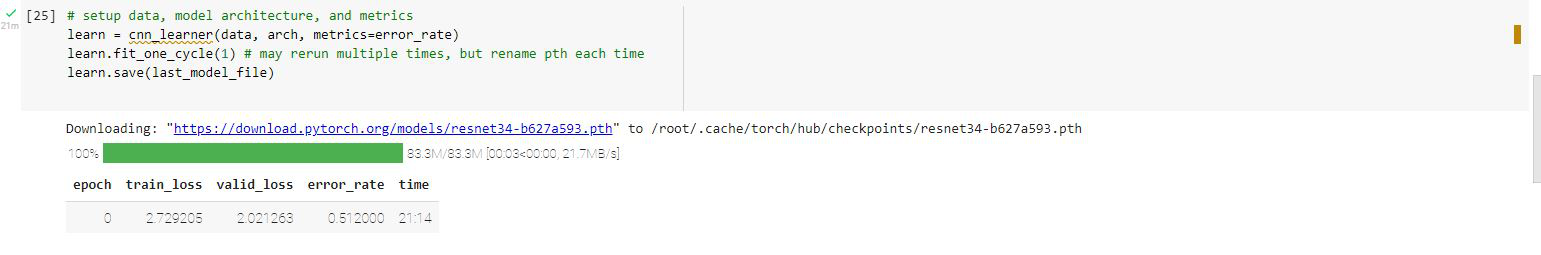

In [ ]:
learner_save_result = open_image(f'{path_last_model}/food-detection-save.jpg')
learner_save_result

In [ ]:
# uses only after save() - memory cleanup
learn.model_dir = path_last_model
learn.data = get_data(batch_size//4, 412)
learn.purge();

In [ ]:
# reload our learned model from file
saved_learn = cnn_learner(data, arch)
saved_learn.load(last_model_file)
_ = saved_learn.model.eval()

## Predictions

### Sample from our kaggle dataset

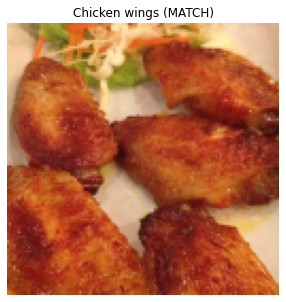

In [ ]:

prediction = saved_learn.predict(sample_image)
predicted = str(prediction[0])
success = 'MATCH' if (predicted == sample_label) else f'SHOULD BE {sample_label}'
sample_image.show(figsize=(7,5), title = f'{predicted} ({success})')

### New images for prediction our trained model
We tested against 10 imported images which proved the success of the model. 


#### Prediction against latest fit cycle

NEW IMAGES RESULTS for /content/drive/MyDrive/Colab Notebooks/last-food-models/food-mini-training-2.pth: Out of 10, prediction match 7 : 70%


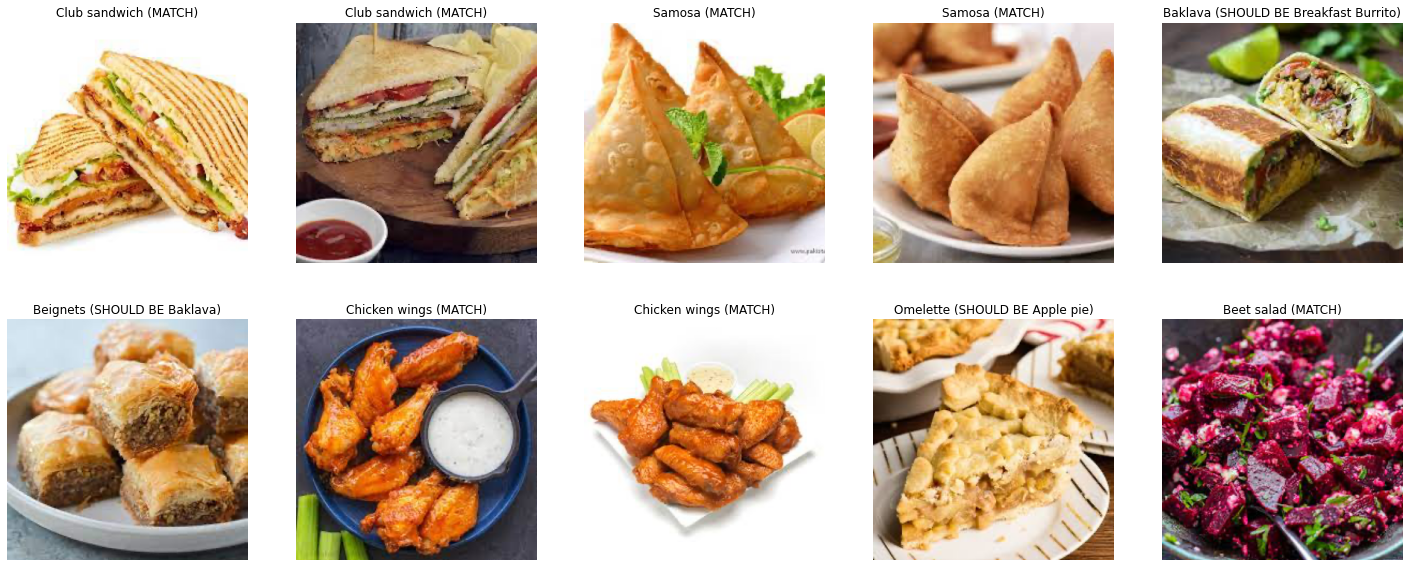

In [ ]:
# introduce 10 new images to test predictions
new_image_responses = []
new_images_matched = 0
max_columns = 5

fig, ax = plt.subplots(2,max_columns, figsize=(25,10))

def get_new_images(path):
  """
  Return set containing image data. return (fastai.vision.image.Image, correct label, image id)
  """
  return [
          (open_image(f'{path_new_images}/clubsandwich.png'), 'Club sandwich', 'clubsandwich'),
          (open_image(f'{path_new_images}/clubsandwich2.png'), 'Club sandwich', 'clubsandwich2'),
          (open_image(f'{path_new_images}/samosa.png'), 'Samosa', 'samosa'),
          (open_image(f'{path_new_images}/samosa2.png'), 'Samosa', 'samosa2'),
          (open_image(f'{path_new_images}/breakfastburrito.png'), 'Breakfast Burrito', 'breakfastburrito'),
          (open_image(f'{path_new_images}/baklava.png'), 'Baklava', 'baklava'),
          (open_image(f'{path_new_images}/wings.png'), 'Chicken wings', 'wings'),
          (open_image(f'{path_new_images}/wings2.png'), 'Chicken wings', 'wings2'),
          (open_image(f'{path_new_images}/applepie.png'), 'Apple pie', 'applepie'),
          (open_image(f'{path_new_images}/beetsalad.png'), 'Beet salad', 'beetsalad'),
  ]

check_images = get_new_images('')
audio_images = []
new_images_count = len(check_images)
curr_row, curr_column = 0, 0

for info in check_images:
  predicted = str(saved_learn.predict(info[0])[0])
  if (predicted == info[1]):
    success = 'MATCH'
    new_images_matched += 1
    audio_images.append(info)
  else: 
    success = f'SHOULD BE {info[1]}'
    audio_images.append((info[0], predicted, info[2])) # changed label

  ax[curr_row, curr_column].imshow(info[0].data.permute(1, 2, 0))
  ax[curr_row, curr_column].set_title(f'{predicted} ({success})')
  ax[curr_row, curr_column].axis('off')

  curr_column += 1
  if curr_column >= max_columns:
    curr_column = 0
    curr_row += 1

print(f'NEW IMAGES RESULTS for {last_model_file}.pth: Out of {new_images_count}, prediction match {new_images_matched} : {(new_images_matched/new_images_count)*100:0.0f}%')

#### Previous prediction with food-mini-training-1.pth


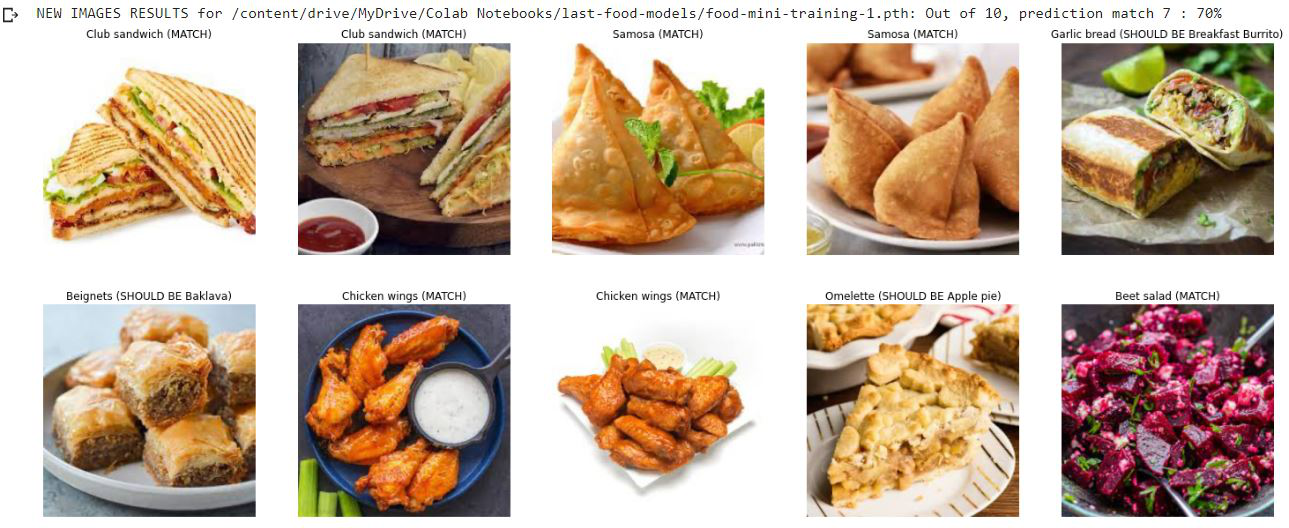

In [ ]:
last_training = open_image(f'{path_last_model}/predict-training-1.jpg')
last_training

### Prediction results
**Training #1 (first fit cycle), below, and training #2 (second fit cycle), above, both predicted 70% accurate and failed on the same 3 foods. However, their prediction with the breakfast burrito and the apple pie differed.**

## Data Visualization

**Data Cleaning:** 

Missing data was negligible. The data was normalized, and the data was collected/imported directly from the Kaggle source (units were images). We are confident after sifting through the data that it is clean and free of inaccurate mistakes. While overwhelming in size, the dataset proved to be easy to work with and gave us a strong foundation for our project goals. 

#### Plot confusion matrix of our saved learner
A confusion matrix is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.

**The confusion matrix shows the ways in which your classification model is confused when it makes predictions.**

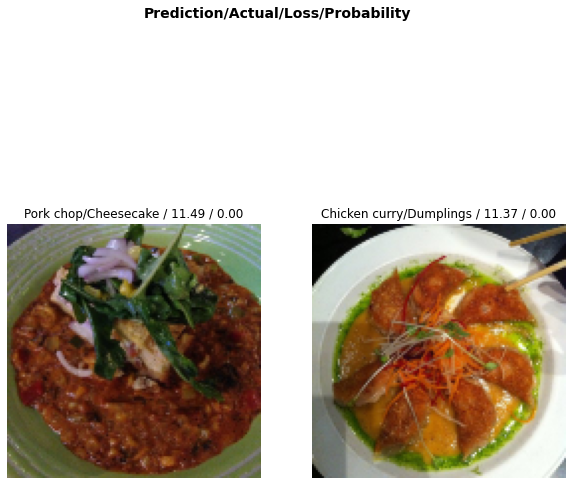

In [ ]:
interp = ClassificationInterpretation.from_learner(saved_learn)
interp.plot_confusion_matrix(figsize=(label_count,label_count))
interp.plot_top_losses(2, figsize=(10,10))

#### Compare saliency of original resnet34 vs our saved tranined model
> In this case using lastest model with 3 fit cycles (food-mini-training-2)

In [ ]:
# imports for saliency visualization (version needed otherwise getting import errors on missing packages below)
!pip install scipy==1.1.0
!pip install keras==2.2.2


(-0.5, 127.5, 127.5, -0.5)

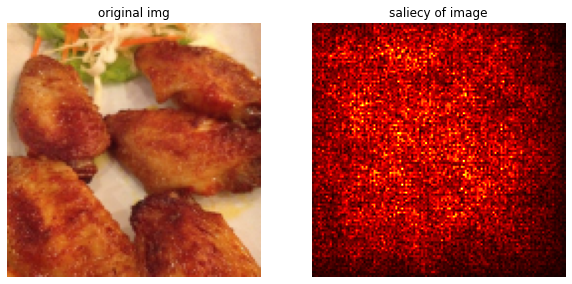

In [ ]:
# single 3d tensor image
img_tensor = sample_image.data
img_tensor4d = img_tensor.unsqueeze(0) # convert 3d to 4d in order to use with models
img_tensor4d.requires_grad_()

def get_saliency_by_model(check_model):
    """
    Return the saliency of a given model
    """
    # resnet34 model and set to eval mode
    model = check_model()
    model.eval()

    # get image score  this model)
    scores = model(img_tensor4d)

    # Get the index corresponding to the maximum score and the maximum score
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    # backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    #  score_max with respect to nodes in the computation grap
    score_max.backward()

    saliency, _ = torch.max(img_tensor4d.grad.data.abs(),dim=1)
    return saliency[0]

saliency_resnet = get_saliency_by_model(arch)

# FUTURE: do saliency for a saved learner
# saliency_saved = get_saliency_by_model(saved_learn.model)

# plot the image and salience as a heatmap, side by side
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img_tensor.permute(1, 2, 0))
ax[0].set_title('original img')
ax[0].axis('off')
ax[1].imshow(saliency_resnet, cmap=plt.cm.hot)
ax[1].set_title('saliecy of image')
ax[1].axis('off')



## Convert to speech
#### Output our new predicted image labels to an audio file.

> You'll note that from our latest training, 3 of the images will tell user the incorrect label (bakalva, apple pie, and breakfast burrito).

In [ ]:
import subprocess
# install text to speech
!apt-get install espeak > /dev/null 2>&1

In [ ]:
# generate audio for our checked images
for info in audio_images:
  _, label, img_id = info

  p1 = subprocess.Popen(['echo', str(label)], stdout=subprocess.PIPE)
  subprocess.check_output(["espeak", "-s", "120", "-w",  f'{path_audio}/{img_id}.wav'], stdin=p1.stdout)

# check audio files created
!ls "$path_audio"

applepie.wav  beetsalad.wav	    clubsandwich2.wav  samosa2.wav  wings2.wav
baklava.wav   breakfastburrito.wav  clubsandwich.wav   samosa.wav   wings.wav


## Ethical Considerations 

Some ethical considerations to mention. 

* This is only a very limited sample of foods. It is based on a western diet and therefore not reflective of other cultures.  

* Would it be helpful for the visually impaired to have glasses that speak to them? Would this draw more attention? 

* At what point does food get classified as a food group for instance? We used apple pie for example, but that doesn’t mean that the model was able to say apple pie a la mode or apple pie with caramel crème fraiche. There are clear limitations. 

* This data could be helpful to identify food objects, yet if it identifies a non-food item and classifies it as food, it could harm the individual who is then relying on this information.


* There was only a 70% chance that the data presented was accurate. If this technology were to be used, it would have to be much more prescise. 



## Conclusion

In conclusion, we were able to successfully map and classify food groups through our machine learning process with a 70% accuracy rate. This was done  running two fit cycles. More cycles may lead to further improvements. 
<br><br>
We found that there were limitations in minor details of the food and that training beyond the existing images would be necessary to capture those minor details that make a food a apple pie vs a baklava or a soup vs a stew, etc... 
<br><br>
We were able to scan new food items, with higher than a guess rate of 70%, so that proved successful. It would appear that the data had its limits even with 100,000 images evaluated. We feel strongly that our data is useful as a start; however, we are aware of the limitations that do exist even in seemingly large datasets given the scope of and variety of food items that exist.  

## Sources
> * Starter: Food Images (notebook):
> > * https://www.kaggle.com/code/illukthegreat/starter-food-images

> * Food Data:
> > * Food Images (Food-101): https://www.kaggle.com/datasets/kmader/food41


> * Saliency map
> > * https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4/